# Entrenamientos RetinaNet

En el presente notebook se realizan los entrenamientos con la arquitectura RetinaNet, para las distintas versiones del dataset, utilizando detectron2 de Meta. La toma de decisiones o conclusiones se desarrollan en el notebook correspondiente con el fin de dar mayor claridad a la explicación.

>Disclaimer: Este cuaderno fue desarrollado completamente en el entorno de Google Colab. Por lo tanto, la compatibilidad con la ejecución local puede no ser del 100%, especialmente en lo que respecta a las imágenes, que se almacenan en formato base64 y pueden ser demasiado grandes para interpretarse aquí. Además de las rutas a los directorios.

>info: Para poder realizar un análisis posterior de los resultados los mismos fueron descargados y cargados en el presente repositorio. Se pueden encontrar en la carpeta de results

## Preparación del entorno

In [1]:
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15787, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 15787 (delta 13), reused 31 (delta 8), pack-reused 15743 (from 1)
Receiving objects: 100% (15787/15787), 6.36 MiB | 8.99 MiB/s, done.
Resolving deltas: 100% (11509/11509), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.7 MB/s eta 0:00:

In [2]:
import torch, detectron2

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Descarga de datasets desde google drive

In [4]:
!mkdir datasets
%cd datasets

/content/datasets


In [7]:
!mkdir dataset_coco_1
%cd dataset_coco_1
!gdown "https://drive.google.com/uc?id=1HJR3c_dGcWNy60yLCWcHfkvE4eUU9BsJ"; unzip dataset_dentex_coco_1.zip; rm dataset_dentex_coco_1.zip
%cd ..

/content/dataset_coco_1
Downloading...
From (original): https://drive.google.com/uc?id=1HJR3c_dGcWNy60yLCWcHfkvE4eUU9BsJ
From (redirected): https://drive.google.com/uc?id=1HJR3c_dGcWNy60yLCWcHfkvE4eUU9BsJ&confirm=t&uuid=7d47de93-6c19-4d79-a91a-2f8cac4b737b
To: /content/dataset_coco_1/dataset_dentex_coco_1.zip
100% 252M/252M [00:05<00:00, 48.0MB/s]
Archive:  dataset_dentex_coco_1.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
  inflating: test/train_110_png.rf.8cac054da6ccd05bf806c6e130b6a081.jpg  
  inflating: test/train_117_png.rf.dea95d574ae806119ba987bdcc66327a.jpg  
  inflating: test/train_118_png.rf.dd91408734c653e07bfa5dd630a44a77.jpg  
  inflating: test/train_149_png.rf.cdad62ea06ada7cc79a9c26a1ced71f4.jpg  
  inflating: test/train_161_png.rf.e6db59aa347737faf140a2b69145c290.jpg  
  inflating: test/train_16_png.rf.d28084b61684cb79faaa7776d6108e06.jpg  
  inflating: test/train_171_png.rf.35e2d1b82ba8c18e7c5f5d73eda9ca15.jpg  
  

In [8]:
!mkdir dataset_coco_2
%cd dataset_coco_2
!gdown "https://drive.google.com/uc?id=104Fs4Qyl0hZwJVGLbjpnRcXz79Ztl7-e"; unzip dataset_dentex_coco_2.zip; rm dataset_dentex_coco_2.zip
%cd ..

/content/dataset_coco_2
Downloading...
From (original): https://drive.google.com/uc?id=104Fs4Qyl0hZwJVGLbjpnRcXz79Ztl7-e
From (redirected): https://drive.google.com/uc?id=104Fs4Qyl0hZwJVGLbjpnRcXz79Ztl7-e&confirm=t&uuid=2e0d4c38-81d5-4580-981f-04626af92c67
To: /content/dataset_coco_2/dataset_dentex_coco_2.zip
100% 238M/238M [00:09<00:00, 25.5MB/s]
Archive:  dataset_dentex_coco_2.zip
   creating: test/
  inflating: test/train_121_png_jpg.rf.5e8c0647092eb75f1478e27b1131c19d.jpg  
  inflating: test/train_124_png_jpg.rf.eda2a609c47ce1f2ce913c48d8c19c87.jpg  
  inflating: test/train_130_png_jpg.rf.883ae18d06ec29233517ee1942fab0f3.jpg  
  inflating: test/train_13_png_jpg.rf.c7a742a46080cd9ed7405f86cf592ae9.jpg  
  inflating: test/train_142_png_jpg.rf.e251a4e43ce1650d5b0db4d61806300b.jpg  
  inflating: test/train_148_png_jpg.rf.5e5ac7aee1951c67ca26e0c7c5cfb5fd.jpg  
  inflating: test/train_151_png_jpg.rf.140da4e4345cd4791f0c29407ee7ce2b.jpg  
  inflating: test/train_158_png_jpg.rf.48d4c980714

In [5]:
!mkdir dataset_coco_3
%cd dataset_coco_3
!gdown "https://drive.google.com/uc?id=19uIFLXV7ku0e7IAqKzmOAei9PUqfFdPg"; unzip dataset_dentex_coco_3.zip; rm dataset_dentex_coco_3.zip
%cd ..

/content/datasets/dataset_coco_3
Downloading...
From (original): https://drive.google.com/uc?id=19uIFLXV7ku0e7IAqKzmOAei9PUqfFdPg
From (redirected): https://drive.google.com/uc?id=19uIFLXV7ku0e7IAqKzmOAei9PUqfFdPg&confirm=t&uuid=4300e98b-a6d5-4973-b344-8ef4143d318b
To: /content/datasets/dataset_coco_3/dataset_dentex_coco_3.zip
100% 293M/293M [00:14<00:00, 20.0MB/s]
Archive:  dataset_dentex_coco_3.zip
   creating: test/
  inflating: test/train_121_png_jpg.rf.a7ca1cb50a79073ac64e5508f9b476d5.jpg  
  inflating: test/train_124_png_jpg.rf.5b014b1b3cda024d60959bd7c4dd127a.jpg  
  inflating: test/train_130_png_jpg.rf.3c1ddb33a79f32a6103d6f51b0420fa2.jpg  
  inflating: test/train_13_png_jpg.rf.9d96cc7ec5368e3a0ca194de15ba184f.jpg  
  inflating: test/train_142_png_jpg.rf.cc7b40022c65b9180d4bca8957d2979b.jpg  
  inflating: test/train_148_png_jpg.rf.1554ad2bd6cb4fde6e0eea4b04acd442.jpg  
  inflating: test/train_151_png_jpg.rf.0ab95d8ea76584566a8593eca074321a.jpg  
  inflating: test/train_158_png_

In [6]:
%cd ..

/content


A continuación se realiza una verificación de las resoluciones de las imagenes en las anotación.

In [9]:
import json
import cv2
import os

carpetas = ['train','test','valid']
datasets = ['dataset_coco_1','dataset_coco_2','dataset_coco_3']

# Ruta al archivo de anotaciones y la carpeta de imágenes

for dataset in datasets:
  for carpeta in carpetas:

    annotations_path = f'/content/datasets/{dataset}/{carpeta}/_annotations.coco.json'
    images_dir = f'/content/datasets/{dataset}/{carpeta}/'

    # Cargar las anotaciones
    with open(annotations_path) as f:
        coco_data = json.load(f)

    # Iterar sobre las anotaciones y verificar los tamaños
    for image_info in coco_data['images']:
        img_path = os.path.join(images_dir, image_info['file_name'])

        # Leer la imagen para obtener las dimensiones reales
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: No se pudo cargar la imagen {img_path}")
            continue
        height, width = img.shape[:2]

        # Comparar con las dimensiones en las anotaciones
        if image_info['height'] != height or image_info['width'] != width:
            print(f"Corrigiendo dimensiones de {image_info['file_name']} de ({image_info['width']}, {image_info['height']}) a ({width}, {height})")
            image_info['height'] = height
            image_info['width'] = width

    # Guardar el archivo corregido
    with open(annotations_path, 'w') as f:
        json.dump(coco_data, f)

Corrigiendo dimensiones de train_585_png_jpg.rf.ff13e26fc1c568620497ff477b7d5dc1.jpg de (1720, 900) a (1721, 901)
Corrigiendo dimensiones de train_3_png_jpg.rf.a21f668fc25ac66c102ae1512199390c.jpg de (1720, 842) a (1720, 843)
Corrigiendo dimensiones de train_411_png_jpg.rf.a1f8246df6f186c5e1f70595bba4db4a.jpg de (1720, 900) a (1721, 901)
Corrigiendo dimensiones de train_353_png_jpg.rf.1fff2d4bf088a7121992a9b33922ab9e.jpg de (1720, 894) a (1721, 895)
Corrigiendo dimensiones de train_143_png_jpg.rf.2985d01b610b19b34d03745fcc7d6380.jpg de (1720, 772) a (1721, 772)
Corrigiendo dimensiones de train_20_png_jpg.rf.4ccc615750c1b0936462acf8e614671c.jpg de (1720, 798) a (1721, 798)
Corrigiendo dimensiones de train_161_png_jpg.rf.5f14df34e449e7694f757463509ae19c.jpg de (1720, 846) a (1721, 846)


## Entrenamientos

A continuación se realizan los entrenamientos del modelo en las distintas versiones del dataset.

### RetinaNet - Dataset 1 - Train 1

Se realizo un entrenamiento con el dataset original con el que empezamos a trabajar sin utilizar data augmentation ni modelos preentrenados.

In [11]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_1_train", {}, "/content/datasets/dataset_coco_1/train/_annotations.coco.json", "/content/datasets/dataset_coco_1/train")
register_coco_instances("my_dataset_1_val", {}, "/content/datasets/dataset_coco_1/valid/_annotations.coco.json", "/content/datasets/dataset_coco_1/valid")
register_coco_instances("my_dataset_1_test", {}, "/content/datasets/dataset_coco_1/test/_annotations.coco.json", "/content/datasets/dataset_coco_1/test")

In [12]:
# Verifica si el dataset ha sido registrado correctamente
print(MetadataCatalog.get("my_dataset_1_train"))
print(MetadataCatalog.get("my_dataset_1_val"))
print(MetadataCatalog.get("my_dataset_1_test"))

# Imprimir el número de imágenes del dataset
dataset_dicts = DatasetCatalog.get("my_dataset_1_train")
print(f"Total imágenes en el dataset de entrenamiento: {len(dataset_dicts)}")

Metadata(name='my_dataset_1_train', json_file='/content/datasets/dataset_coco_1/train/_annotations.coco.json', image_root='/content/datasets/dataset_coco_1/train', evaluator_type='coco')
Metadata(name='my_dataset_1_val', json_file='/content/datasets/dataset_coco_1/valid/_annotations.coco.json', image_root='/content/datasets/dataset_coco_1/valid', evaluator_type='coco')
Metadata(name='my_dataset_1_test', json_file='/content/datasets/dataset_coco_1/test/_annotations.coco.json', image_root='/content/datasets/dataset_coco_1/test', evaluator_type='coco')
[10/11 16:38:01 d2.data.datasets.coco]: Loaded 529 images in COCO format from /content/datasets/dataset_coco_1/train/_annotations.coco.json
Total imágenes en el dataset de entrenamiento: 529


A continuación se realiza la configuración del entrenamiento, donde se puede observar que no utilizan pesos preentrenados para el entrenamiento. Además no se aplican técnicas de data augmentation.

In [13]:
import detectron2
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_1_train",)
cfg.DATASETS.TEST = ("my_dataset_1_val",)
cfg.MODEL.RETINANET.NUM_CLASSES = 4
cfg.OUTPUT_DIR = "/output/dataset_1/train_1/"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.DEVICE = "cuda"
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.CHECKPOINT_PERIOD = 200
cfg.TEST.EVAL_PERIOD = 500

In [14]:
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        os.makedirs(output_folder, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Entrenar el modelo
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/11 16:38:15 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

R-50.pkl: 102MB [00:00, 183MB/s]                            

[10/11 16:38:15 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[10/11 16:38:15 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
head.bbox_pred.{bias, weight}
head.bbox_subnet.0.{bias, weight}
head.bbox_subnet.2.{bias, weight}
head.bbox_subnet.4.{bias, weight}
head.bbox_subnet.6.{bias, weight}
head.cls_score.{bias, weight}
head.cls_subnet.0.{bias, weight}
head.cls_subnet.2.{bias, weight}
head.cls_subnet.4.{bias, weight}
head.cls_subnet.6.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[10/11 16:38:15 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/11 16:39:50 d2.utils.events]:  eta: 2:19:18  iter: 19  total_loss: 2.637  loss_cls: 1.657  loss_box_reg: 0.9795    time: 4.4481  last_time: 4.1675  data_time: 1.5324  last_data_time: 1.2963   lr: 9.9905e-05  max_mem: 11775M
[10/11 16:41:26 d2.utils.events]:  eta: 2:20:40  iter: 39  total_loss: 1.913  loss_cls: 1.205  loss_box_reg: 0.7068    time: 4.5384  last_time: 5.0377  data_time: 1.5792  last_data_time: 1.9402   lr: 0.0001998  max_mem: 12198M
[10/11 16:42:59 d2.utils.events]:  eta: 2:20:56  iter: 59  total_loss: 1.817  loss_cls: 1.145  loss_box_reg: 0.6725    time: 4.5670  last_time: 5.3064  data_time: 1.5201  last_data_time: 2.2067   lr: 0.0002997  max_mem: 12199M
[10/11 16:44:32 d2.utils.events]:  eta: 2:19:41  iter: 79  total_loss: 1.756  loss_cls: 1.125  loss_box_reg: 0.632    time: 4.5907  last_time: 4.3576  data_time: 1.5214  last_data_time: 1.3064   lr: 0.00039961  max_mem: 12206M
[10/11 16:46:04 d2.utils.events]:  eta: 2:19:19  iter: 99  total_loss: 1.701  loss_cls: 1.1

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Configurar el evaluador para COCO
evaluator = COCOEvaluator("my_dataset_1_test", cfg, False, output_dir="./output/dataset_1/train_1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_1_test")

# Ejecutar la evaluación
inference_on_dataset(trainer.model, val_loader, evaluator)

[10/11 19:14:35 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [10/11 19:14:35 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/11 19:14:35 d2.data.datasets.coco]: Loaded 75 images in COCO format from /content/datasets/dataset_coco_1/test/_annotations.coco.json
[10/11 19:14:35 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |  category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
|    Caries     | 219          | Deep Caries | 45           |  Impacted  | 78           |
| Periapical .. | 24           |             |              |            |              |
|     total     | 366          |             |              |            |              |
[10/11 19:14:35 d2.data.dataset_mapper]: [Datas

OrderedDict([('bbox',
              {'AP': 25.70468709155293,
               'AP50': 45.206318155728184,
               'AP75': 25.807234492068925,
               'APs': nan,
               'APm': nan,
               'APl': 25.705178867071186,
               'AP-Caries': 23.355724337292187,
               'AP-Deep Caries': 23.604986800805307,
               'AP-Impacted': 49.09270413125675,
               'AP-Periapical Lesion': 6.765333096857471})])

### RetinaNet - Dataset 2 - Train 1

A continuación se realiza el entrenamiento con el dataset correctmanete etiquetado pero sin aplicar un modelo preentrenado o tecnicas de data augmentation.

In [28]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_2_train", {}, "/content/datasets/dataset_coco_2/train/_annotations.coco.json", "/content/datasets/dataset_coco_2/train")
register_coco_instances("my_dataset_2_val", {}, "/content/datasets/dataset_coco_2/valid/_annotations.coco.json", "/content/datasets/dataset_coco_2/valid")
register_coco_instances("my_dataset_2_test", {}, "/content/datasets/dataset_coco_2/test/_annotations.coco.json", "/content/datasets/dataset_coco_2/test")

In [29]:
# Verifica si el dataset ha sido registrado correctamente
print(MetadataCatalog.get("my_dataset_2_train"))
print(MetadataCatalog.get("my_dataset_2_val"))
print(MetadataCatalog.get("my_dataset_2_test"))

# Imprimir el número de imágenes del dataset
dataset_dicts = DatasetCatalog.get("my_dataset_2_train")
print(f"Total imágenes en el dataset de entrenamiento: {len(dataset_dicts)}")

Metadata(name='my_dataset_2_train', json_file='/content/datasets/dataset_coco_2/train/_annotations.coco.json', image_root='/content/datasets/dataset_coco_2/train', evaluator_type='coco', thing_classes=['caries', 'corona', 'diente impactado', 'endodoncia', 'implante'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4})
Metadata(name='my_dataset_2_val', json_file='/content/datasets/dataset_coco_2/valid/_annotations.coco.json', image_root='/content/datasets/dataset_coco_2/valid', evaluator_type='coco', thing_classes=['caries', 'corona', 'diente impactado', 'endodoncia', 'implante'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4})
Metadata(name='my_dataset_2_test', json_file='/content/datasets/dataset_coco_2/test/_annotations.coco.json', image_root='/content/datasets/dataset_coco_2/test', evaluator_type='coco', thing_classes=['caries', 'corona', 'diente impactado', 'endodoncia', 'implante'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4})


In [30]:
import detectron2
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_2_train",)
cfg.DATASETS.TEST = ("my_dataset_2_val",)
cfg.MODEL.RETINANET.NUM_CLASSES = 5
cfg.OUTPUT_DIR = "/output/dataset_2/train_1/"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.DEVICE = "cuda"
cfg.DATALOADER.NUM_WORKERS = 2

In [31]:
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        os.makedirs(output_folder, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Entrenar el modelo
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/11 22:10:02 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
head.bbox_pred.{bias, weight}
head.bbox_subnet.0.{bias, weight}
head.bbox_subnet.2.{bias, weight}
head.bbox_subnet.4.{bias, weight}
head.bbox_subnet.6.{bias, weight}
head.cls_score.{bias, weight}
head.cls_subnet.0.{bias, weight}
head.cls_subnet.2.{bias, weight}
head.cls_subnet.4.{bias, weight}
head.cls_subnet.6.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[10/11 22:10:03 d2.engine.train_loop]: Starting training from iteration 0
[10/11 22:11:29 d2.utils.events]:  eta: 2:15:38  iter: 19  total_loss: 2.749  loss_cls: 1.712  loss_box_reg: 1.037    time: 4.3416  last_time: 4.0861  data_time: 1.3271  last_data_time: 1.0821   lr: 9.9905e-05  max_mem: 12509M
[10/11 22:13:01 d2.utils.events]:  eta: 2:18:14  iter: 39  total_loss: 1.73  loss_cls: 1.085  loss_box_reg: 0.6448    time: 4.4767  last_time: 4.9385  data_time: 1.4404  last_data_time: 1.8412   lr: 0.0001998  max_mem: 12511M
[10/11 22:14:31 d2.utils.events]:  eta: 2:17:15  iter: 59  total_loss: 1.631  loss_cls: 1.029  loss_box_reg: 0.6022    time: 4.4851  last_time: 4.3945  data_time: 1.3790  last_data_time: 1.0942   lr: 0.0002997  max_mem: 12511M
[10/11 22:16:02 d2.utils.events]:  eta: 2:16:17  iter: 79  total_loss: 1.767  loss_cls: 1.123  loss_box_reg: 0.6341    time: 4.4958  last_time: 5.4167  data_time: 1.3812  last_data_time: 1.8421   lr: 0.00039961  max_mem: 12511M
[10/11 22:17:32 d2

In [32]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Configurar el evaluador para COCO
evaluator = COCOEvaluator("my_dataset_2_test", cfg, False, output_dir="./output/dataset_2/train_1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_2_test")

# Ejecutar la evaluación
inference_on_dataset(trainer.model, val_loader, evaluator)

[10/12 00:40:28 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [10/12 00:40:28 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/12 00:40:28 d2.data.datasets.coco]: Loaded 80 images in COCO format from /content/datasets/dataset_coco_2/test/_annotations.coco.json
[10/12 00:40:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/12 00:40:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/12 00:40:28 d2.data.common]: Serializing 80 elements to byte tensors and concatenating them all ...
[10/12 00:40:28 d2.data.common]: Serialized dataset takes 0.03 MiB
[10/12 00:40:28 d2.evaluation.evaluator]: Start inference on 80 batches
[10/12 00:40:30 d2.evaluation.evaluator

OrderedDict([('bbox',
              {'AP': 45.016084600487424,
               'AP50': 84.48533636600662,
               'AP75': 40.957757059166525,
               'APs': nan,
               'APm': 32.65575628719126,
               'APl': 45.672021250305264,
               'AP-caries': 30.0326349724503,
               'AP-corona': 60.0685752130896,
               'AP-diente impactado': 57.160462356488395,
               'AP-endodoncia': 35.90455904126693,
               'AP-implante': 41.914191419141915})])

[10/12 00:40:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /output/dataset_2/train_2/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Predicted class: 1, Confidence: 0.999472439289093
Predicted class: 1, Confidence: 0.9969165325164795
Predicted class: 1, Confidence: 0.9795520901679993
Predicted class: 0, Confidence: 0.9745683670043945
Predicted class: 3, Confidence: 0.8870625495910645
Predicted class: 2, Confidence: 0.7937062978744507
Predicted class: 0, Confidence: 0.7795013785362244
[10/12 00:40:39 d2.data.datasets.coco]: Loaded 80 images in COCO format from /content/datasets/dataset_coco_2/test/_annotations.coco.json


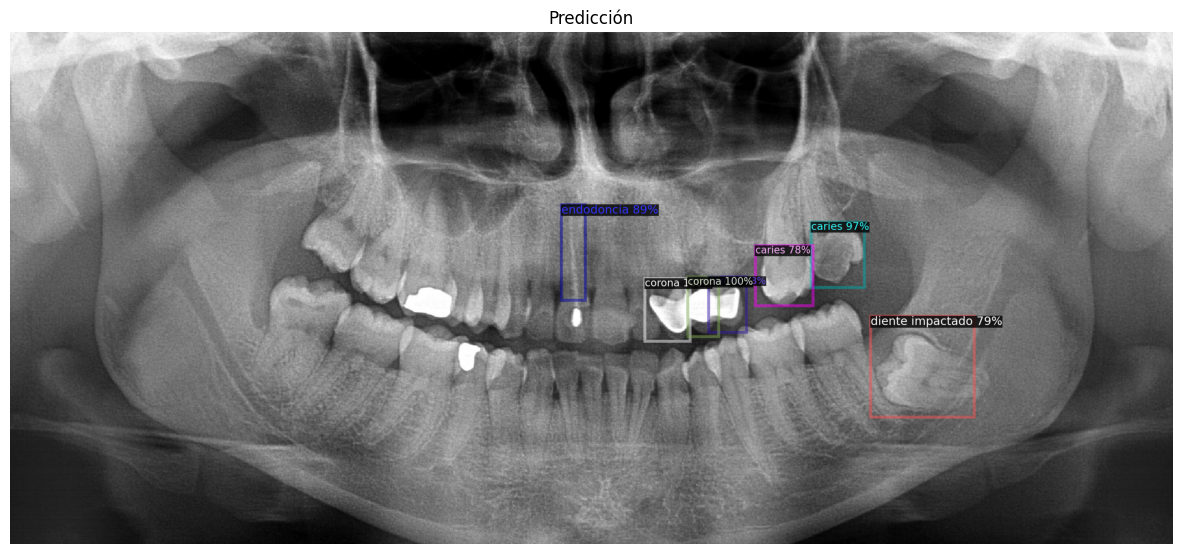

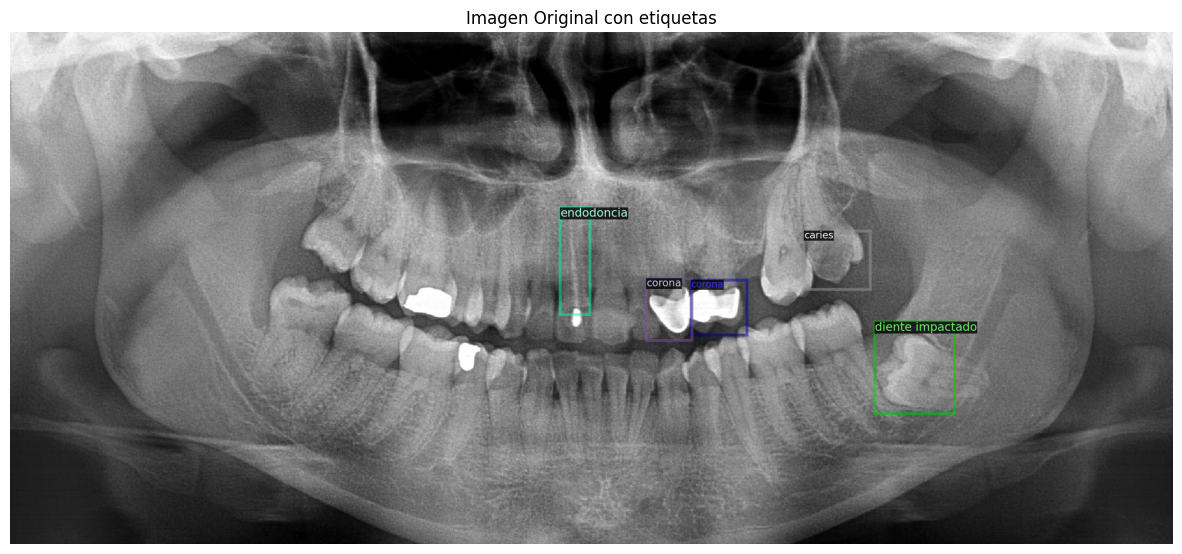

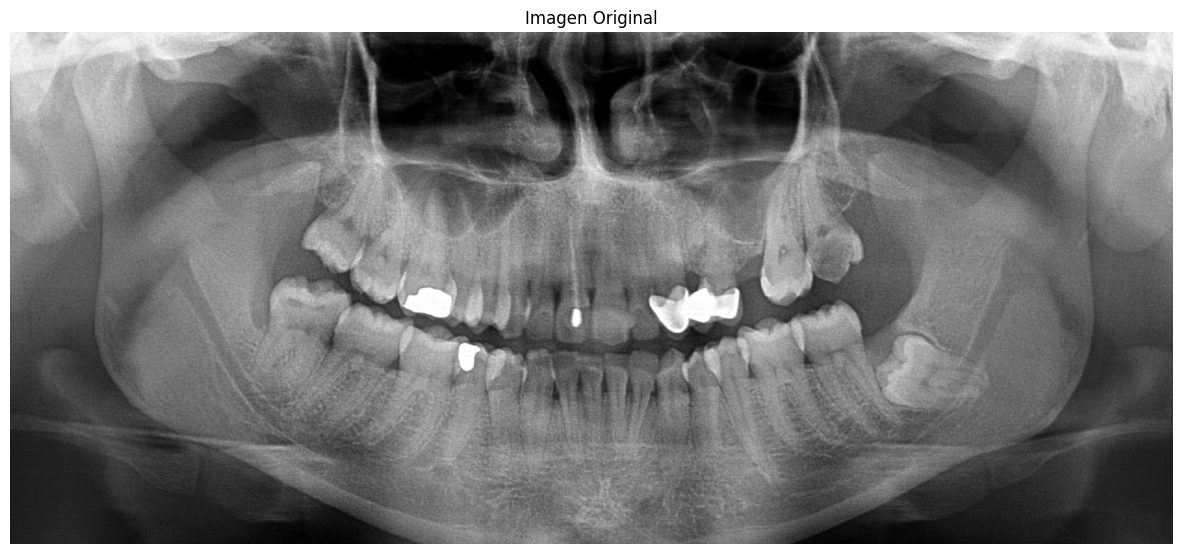

In [33]:
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

# Cargar el modelo entrenado
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # Umbral de confianza para las predicciones
predictor = DefaultPredictor(cfg)

# Cargar una imagen para realizar la inferencia
image_path = "/content/datasets/dataset_coco_2/test/train_151_png_jpg.rf.140da4e4345cd4791f0c29407ee7ce2b.jpg"
im = cv2.imread(image_path)

# Realizar predicción
outputs = predictor(im)

# Print the predicted classes and their confidence scores
for i in range(len(outputs["instances"])):
  pred_class = outputs["instances"].pred_classes[i]
  score = outputs["instances"].scores[i]
  print(f"Predicted class: {pred_class}, Confidence: {score}")

# Obtener las anotaciones del dataset para la imagen
dataset_dicts = DatasetCatalog.get("my_dataset_2_test")  # Asegúrate de usar el nombre correcto del dataset
image_name = os.path.basename(image_path)
for d in dataset_dicts:
    if d["file_name"] == image_path:
        annotations = d["annotations"]
        break

# Visualizar las predicciones
v_pred = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))

# Visualizar las anotaciones del dataset
v_gt = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v_gt = v_gt.draw_dataset_dict(d)

# Mostrar las imágenes usando Matplotlib
plt.figure(figsize=(15, 10))
plt.title('Predicción')
plt.imshow(v_pred.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 10))
plt.title('Imagen Original con etiquetas')
plt.imshow(v_gt.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 10))
plt.title('Imagen Original')
plt.imshow(im[:, :, ::-1])
plt.axis('off')
plt.show()

### RetinaNet - Dataset 3 - Train 1

A continuación se utiliza el mismo datasets pero con tecnicas de aumento de datos, aplicadas directamente en roboflow, y pesos preentrenados.

In [10]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_3_train", {}, "/content/datasets/dataset_coco_3/train/_annotations.coco.json", "/content/datasets/dataset_coco_3/train")
register_coco_instances("my_dataset_3_val", {}, "/content/datasets/dataset_coco_3/valid/_annotations.coco.json", "/content/datasets/dataset_coco_3/valid")
register_coco_instances("my_dataset_3_test", {}, "/content/datasets/dataset_coco_3/test/_annotations.coco.json", "/content/datasets/dataset_coco_3/test")

In [11]:
# Verifica si el dataset ha sido registrado correctamente
print(MetadataCatalog.get("my_dataset_3_train"))
print(MetadataCatalog.get("my_dataset_3_val"))
print(MetadataCatalog.get("my_dataset_3_test"))

# Imprimir el número de imágenes del dataset
dataset_dicts = DatasetCatalog.get("my_dataset_3_train")
print(f"Total imágenes en el dataset de entrenamiento: {len(dataset_dicts)}")

Metadata(name='my_dataset_3_train', json_file='/content/datasets/dataset_coco_3/train/_annotations.coco.json', image_root='/content/datasets/dataset_coco_3/train', evaluator_type='coco')
Metadata(name='my_dataset_3_val', json_file='/content/datasets/dataset_coco_3/valid/_annotations.coco.json', image_root='/content/datasets/dataset_coco_3/valid', evaluator_type='coco')
Metadata(name='my_dataset_3_test', json_file='/content/datasets/dataset_coco_3/test/_annotations.coco.json', image_root='/content/datasets/dataset_coco_3/test', evaluator_type='coco')
[10/12 12:00:48 d2.data.datasets.coco]: Loaded 1692 images in COCO format from /content/datasets/dataset_coco_3/train/_annotations.coco.json
Total imágenes en el dataset de entrenamiento: 1692


In [14]:
import detectron2
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_3_train",)
cfg.DATASETS.TEST = ("my_dataset_3_val",)
cfg.MODEL.RETINANET.NUM_CLASSES = 5
cfg.OUTPUT_DIR = "/content/output/dataset_3/train_1/"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.DEVICE = "cuda"
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")

In [15]:
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        os.makedirs(output_folder, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Entrenar el modelo
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/12 12:02:44 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

head.cls_score.{bias, weight}
  pixel_mean
  pixel_std


[10/12 12:02:44 d2.engine.train_loop]: Starting training from iteration 0
[10/12 12:04:05 d2.utils.events]:  eta: 2:11:03  iter: 19  total_loss: 2.583  loss_cls: 1.742  loss_box_reg: 0.829    time: 4.0003  last_time: 4.0126  data_time: 0.7993  last_data_time: 0.6228   lr: 9.9905e-05  max_mem: 12792M
[10/12 12:05:29 d2.utils.events]:  eta: 2:13:09  iter: 39  total_loss: 1.564  loss_cls: 1.081  loss_box_reg: 0.4788    time: 4.1085  last_time: 4.2735  data_time: 0.7825  last_data_time: 0.9069   lr: 0.0001998  max_mem: 12792M
[10/12 12:06:52 d2.utils.events]:  eta: 2:12:23  iter: 59  total_loss: 1.245  loss_cls: 0.8968  loss_box_reg: 0.3561    time: 4.1157  last_time: 3.8935  data_time: 0.7132  last_data_time: 0.5837   lr: 0.0002997  max_mem: 12792M
[10/12 12:08:14 d2.utils.events]:  eta: 2:09:46  iter: 79  total_loss: 1.067  loss_cls: 0.7323  loss_box_reg: 0.3569    time: 4.1216  last_time: 3.8969  data_time: 0.7727  last_data_time: 0.5734   lr: 0.00039961  max_mem: 12792M
[10/12 12:09:38

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Configurar el evaluador para COCO
evaluator = COCOEvaluator("my_dataset_3_test", cfg, False, output_dir="/content/output/dataset_3/train_1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_3_test")

# Ejecutar la evaluación
inference_on_dataset(trainer.model, val_loader, evaluator)

[10/12 14:23:49 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [10/12 14:23:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/12 14:23:49 d2.data.datasets.coco]: Loaded 80 images in COCO format from /content/datasets/dataset_coco_3/test/_annotations.coco.json
[10/12 14:23:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/12 14:23:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/12 14:23:49 d2.data.common]: Serializing 80 elements to byte tensors and concatenating them all ...
[10/12 14:23:49 d2.data.common]: Serialized dataset takes 0.03 MiB
[10/12 14:23:49 d2.evaluation.evaluator]: Start inference on 80 batches
[10/12 14:23:50 d2.evaluation.evaluator

OrderedDict([('bbox',
              {'AP': 50.171461024412636,
               'AP50': 86.45595927206719,
               'AP75': 49.67092493837599,
               'APs': nan,
               'APm': 46.22197339784144,
               'APl': 54.79763823357339,
               'AP-caries': 34.48862717776283,
               'AP-corona': 57.03269772337379,
               'AP-diente impactado': 61.46770195088169,
               'AP-endodoncia': 42.587750217239616,
               'AP-implante': 55.28052805280528})])

[10/12 14:24:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/dataset_3/train_1/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Predicted class: 2, Confidence: 0.949648916721344
Predicted class: 2, Confidence: 0.9419946074485779
Predicted class: 3, Confidence: 0.9033075571060181
Predicted class: 0, Confidence: 0.53919517993927
Predicted class: 2, Confidence: 0.40646040439605713
Predicted class: 3, Confidence: 0.3578019440174103
Predicted class: 3, Confidence: 0.30987632274627686
Predicted class: 0, Confidence: 0.3041899800300598
[10/12 14:24:59 d2.data.datasets.coco]: Loaded 80 images in COCO format from /content/datasets/dataset_coco_3/test/_annotations.coco.json


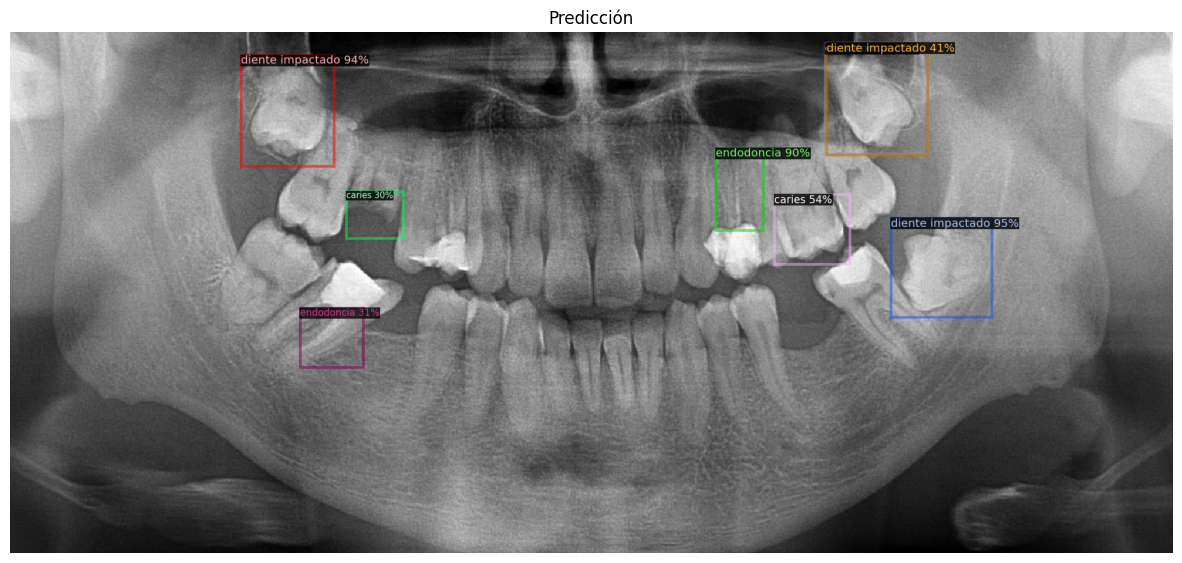

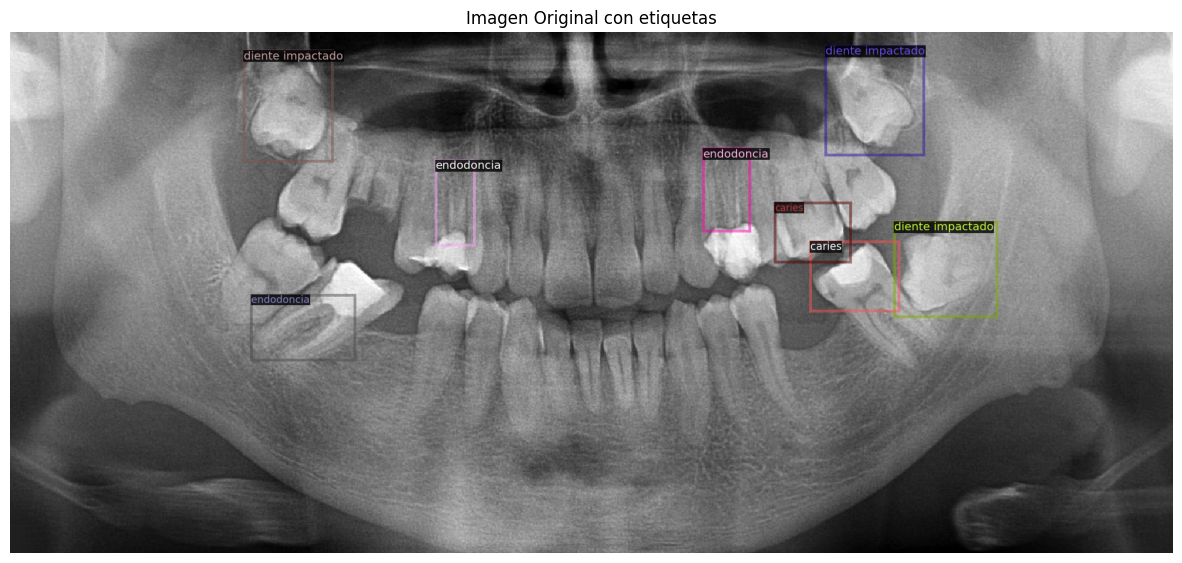

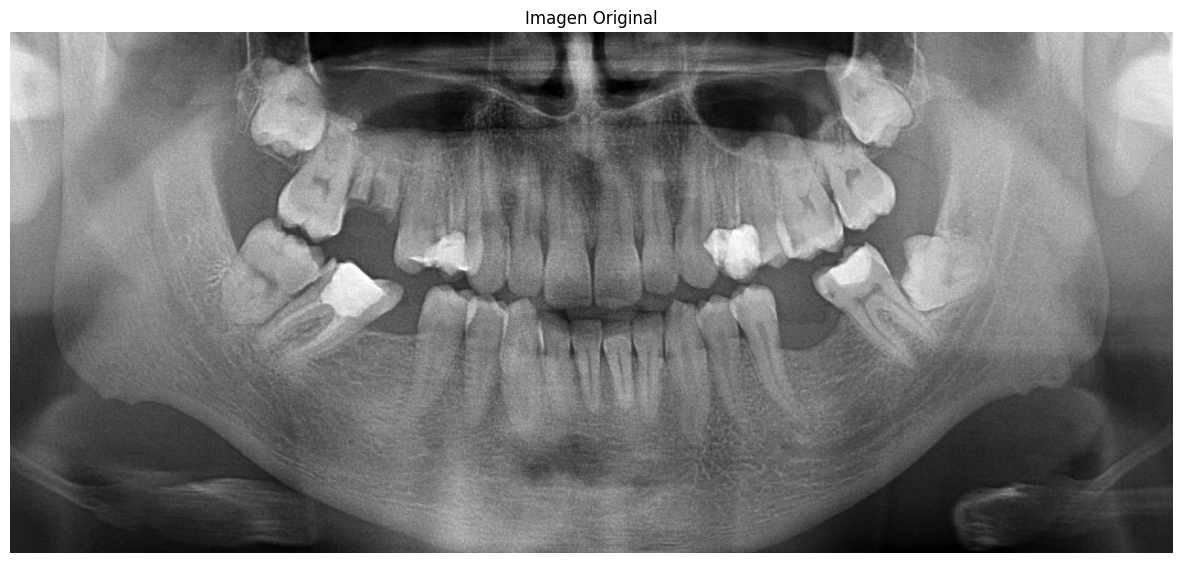

In [20]:
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

# Cargar el modelo entrenado
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3  # Umbral de confianza para las predicciones
predictor = DefaultPredictor(cfg)

# Cargar una imagen para realizar la inferencia
image_path = "/content/datasets/dataset_coco_3/test/train_13_png_jpg.rf.9d96cc7ec5368e3a0ca194de15ba184f.jpg"
im = cv2.imread(image_path)

# Realizar predicción
outputs = predictor(im)

# Print the predicted classes and their confidence scores
for i in range(len(outputs["instances"])):
  pred_class = outputs["instances"].pred_classes[i]
  score = outputs["instances"].scores[i]
  print(f"Predicted class: {pred_class}, Confidence: {score}")

# Obtener las anotaciones del dataset para la imagen
dataset_dicts = DatasetCatalog.get("my_dataset_3_test")  # Asegúrate de usar el nombre correcto del dataset
image_name = os.path.basename(image_path)
for d in dataset_dicts:
    if d["file_name"] == image_path:
        annotations = d["annotations"]
        break

# Visualizar las predicciones
v_pred = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))

# Visualizar las anotaciones del dataset
v_gt = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v_gt = v_gt.draw_dataset_dict(d)

# Mostrar las imágenes usando Matplotlib
plt.figure(figsize=(15, 10))
plt.title('Predicción')
plt.imshow(v_pred.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 10))
plt.title('Imagen Original con etiquetas')
plt.imshow(v_gt.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 10))
plt.title('Imagen Original')
plt.imshow(im[:, :, ::-1])
plt.axis('off')
plt.show()